In [2]:
import bisect
import collections
import math
import matplotlib.pyplot as plt
from util import filetools
from util import unpack
from util import plotter
from util import vectors
import pandas as pd
import glob
import scipy.stats
import numpy as np
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (20.0, 16.0)
pylab.rcParams['font.size'] = 2*pylab.rcParams['font.size']

In [2]:
def get_outfile(datadir):
    
    return glob.glob(datadir + '/*.out')[0]

In [1]:
datadir = '/home/erubin/thesis/gpfs/experiments/test64k-w2-m200-r1.5/'

In [4]:
confs = filetools.get_conf_files(datadir)

In [5]:
df = unpack.DataFile(confs[0]).unpack()

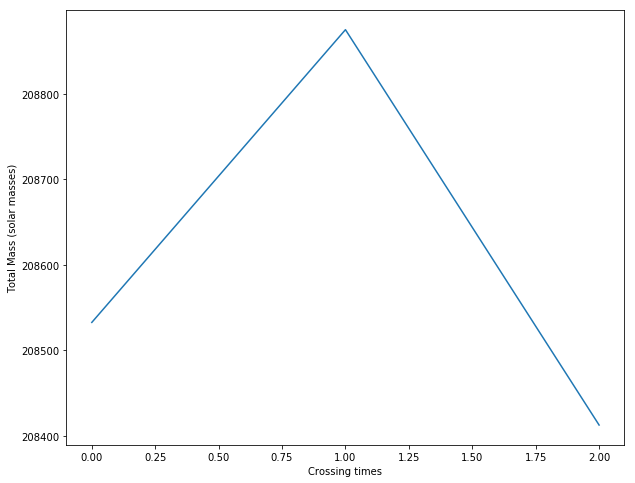

In [3]:
plotter.mass_v_time(datadir)

In [8]:
plotter.avg_ke_v_time(data_dir=datadir)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [3]:
def cumulative_density_profile(datadir, t=0, target=float('inf')):
    initial = filetools.get_conf_files(datadir)[t]
    df = unpack.DataFile(initial).unpack()
    radii = vectors.magnitudes3(df.pos)
    massRad = sorted(list(zip(radii, df.masses)))
    last = bisect.bisect(massRad, (target, 0))
    rad = [pair[0]*df.to_parsecs for pair in massRad[:last]]
    cumMass = [pair[1] for pair in massRad[:last]]
    for i in xrange(1, len(cumMass)):
        cumMass[i] = cumMass[i] + cumMass[i-1]
        
    fig, ax = plt.subplots(1,1)
    ax.loglog(rad, cumMass)
    mtot = "{} solar masses".format(cumMass[-1]*df.to_solar_mass)    
    print "{} stars constituting {} within {} pc of center".format(last, mtot, target)

    

def density_profile(datair, t=0, target=35):
    initial = filetools.get_conf_files(datadir)[t]
    df = unpack.DataFile(initial).unpack()
    radii = vectors.magnitudes3(df.pos)
    massRad = sorted(list(zip(radii, df.masses)))
    last = bisect.bisect(massRad, (target, 0))
    rad = [pair[0]*df.to_parsecs for pair in massRad[:last]]
    mass = [pair[1]*df.to_solar_mass for pair in massRad[:last]]
    stride = 8
    density = [0 for _ in xrange(0, len(rad)/stride)]
    radsparse = [0 for _ in xrange(0, len(rad)/stride)]
    
    for i in xrange(stride, len(mass), stride):
        massaccum = 0
        volume = ((4./3. * math.pi * rad[i]**3) - (4./3. * math.pi * rad[i-stride]**3))
        for j in xrange(0, stride):
            massaccum += mass[i-j]
        
        density[i / stride + i % stride] = massaccum / volume
        
    for i in xrange(stride, len(rad), stride):
        radaccum = 0
        for j in xrange(0, stride):
            radaccum += rad[i-j]
            
        radsparse[i / stride + i % stride] = radaccum / stride
        
    
    fig, ax = plt.subplots(1,1)

    ax.loglog(radsparse, density, alpha=0.7)



64000 stars constituting 207486.152935 solar masses within 500 pc of center


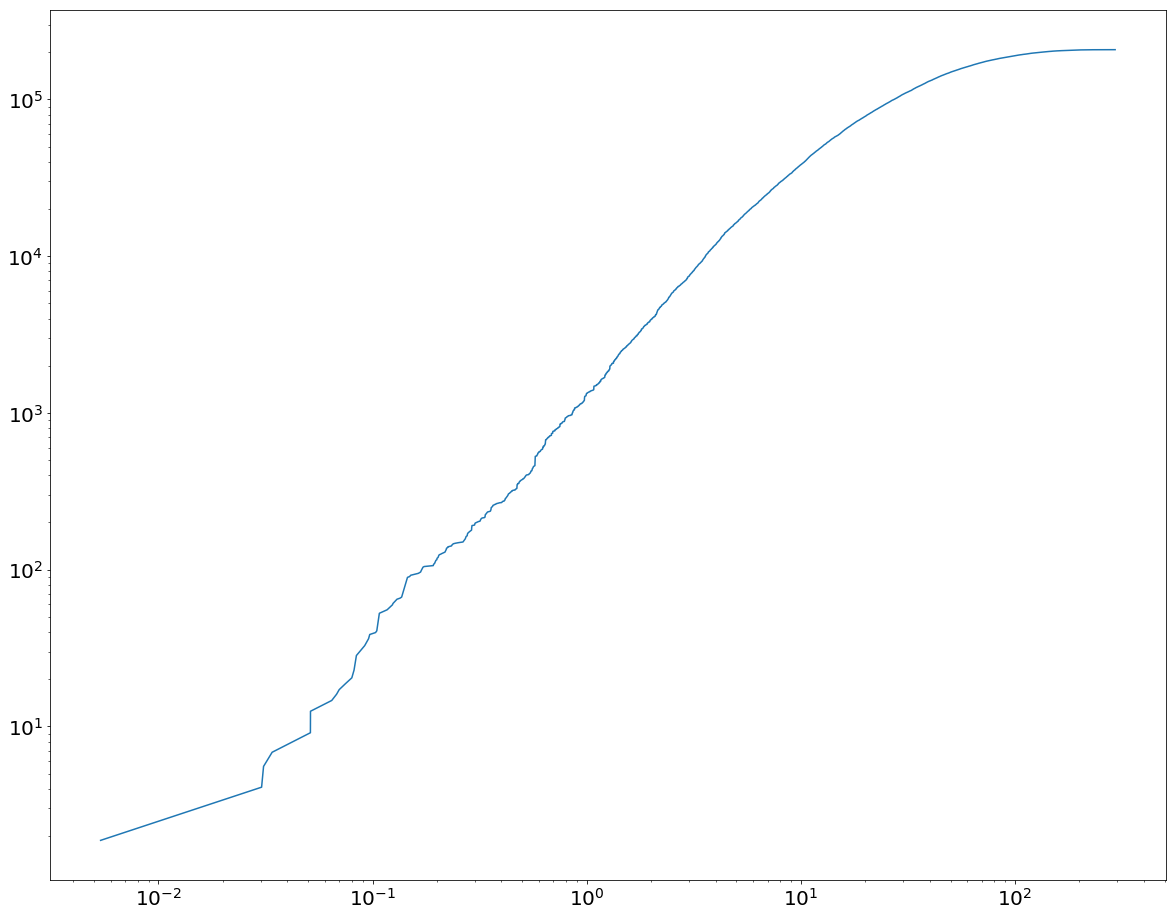

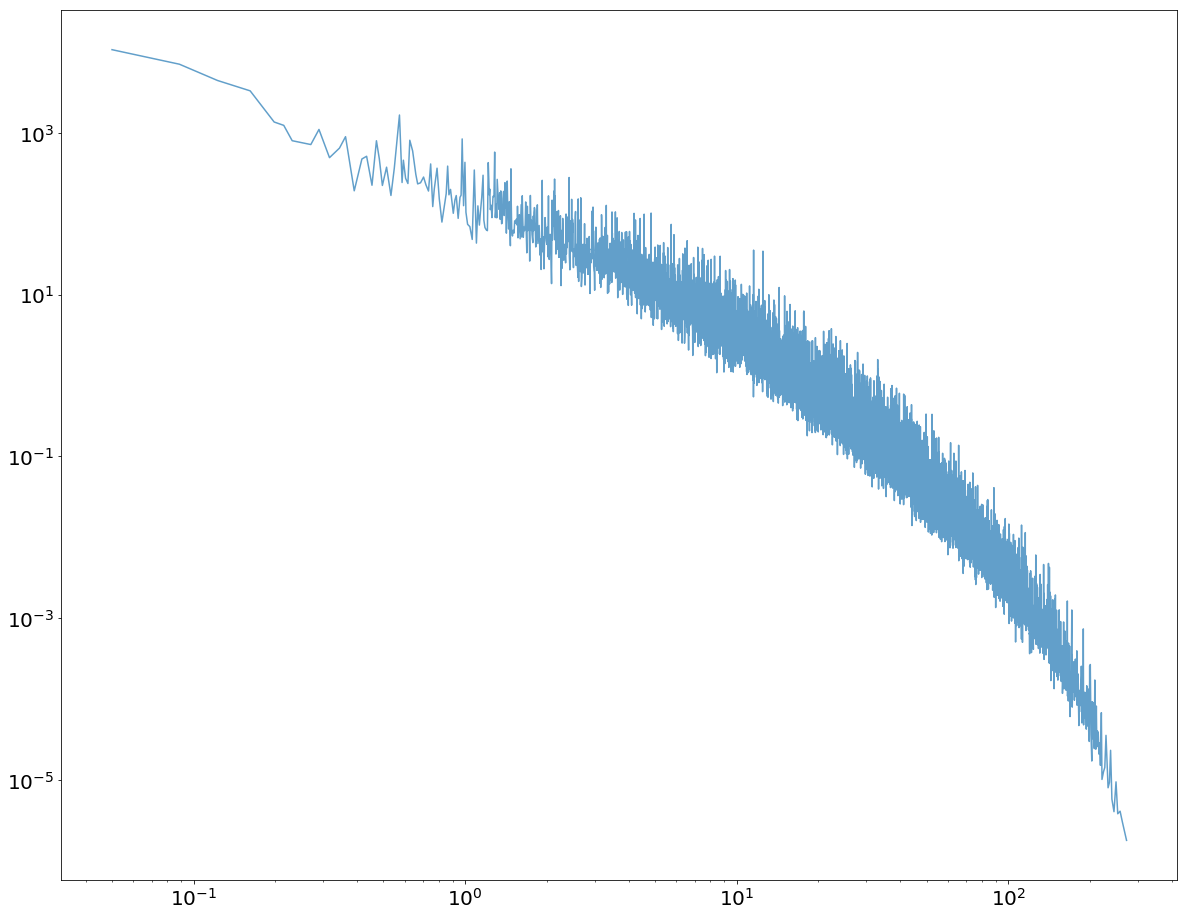

In [7]:
t=0
cumulative_density_profile(datadir, t=t, target=500)
#cumulative_density_profile(datadir, t=90, target=5)

density_profile(datadir, t=t, target=500)
#density_profile(datadir, t=90, target=5)

In [24]:
def mass_within_v_time(datadir, radius=0.001):
    
    masses = []
    times = []
    for conf in filetools.get_conf_files(datadir):
        df = unpack.DataFile(conf).unpack()
        radii = vectors.magnitudes3(df.pos)
        massRad = sorted(list(zip(radii, df.masses)))
        last = bisect.bisect(massRad, (radius, 0))
        rad = [pair[0] for pair in massRad[:last]]
        cumMass = [pair[1] for pair in massRad[:last]]
        for i in xrange(1, len(cumMass)):
            cumMass[i] = cumMass[i] + cumMass[i-1]
            
        masses.append(cumMass[-1]*df.to_solar_mass)
        times.append(df.header2['time[nb]'] * df.to_myr)
        
    
    fig, ax = plt.subplots(1,1)
    ax.plot(times, masses)
    

In [23]:
def half_mass_radius(datadir):
    rads = []
    times = []
    for conf in filetools.get_conf_files(datadir):
        df = unpack.DataFile(conf).unpack()
        radii = vectors.magnitudes3(df.pos)
        massRad = sorted(list(zip(radii, df.masses)))
        cumMass = [pair[1] for pair in massRad]
        for i in xrange(1, len(cumMass)):
            cumMass[i] = cumMass[i] + cumMass[i-1]
            
        halfmass = cumMass[-1]/2.
        halfMi = bisect.bisect(cumMass, halfmass)
        halfR = massRad[halfMi][0]
        rads.append(halfR * df.to_parsecs)
        times.append(df.header2['time[nb]'])
        
    
    fig, ax = plt.subplots(1,1)
    ax.plot(times, rads)    

In [9]:
def g30_core_radius(datadir):
    globs = datadir+'/global.30'
    df = pd.read_csv(globs, sep='\s+', index_col=False)
    cores = df['RC[PC]']
    times = df['TIME[NB}']
    fig, ax = plt.subplots(1,1)
    ax.plot(times, cores)
    

def g30_half_mass_radius(datadir):
    globs = datadir+'/global.30'
    df = pd.read_csv(globs, sep='\s+', index_col=False)
    hmrs = df['RSCALE[PC]']
    times = df['TIME[NB}']
    fig, ax = plt.subplots(1,1)
    ax.plot(times, hmrs)    

In [8]:
# def potential_energy(datadir):
#     out = get_outfile(datadir)
    
#     with open(out, 'r') as f:
        
#     times = df['TIME[NB}']
#     fig, ax = plt.subplots(1,1)
#     ax.plot(times, hmrs)    
    
def kinetic_energy(datadir):
    globs = datadir+'/global.30'
    df = pd.read_csv(globs, sep='\s+', index_col=False)
    hmrs = df['RSCALE[PC]']
    times = df['TIME[NB}']
    fig, ax = plt.subplots(1,1)
    ax.plot(times, hmrs)    

In [64]:
mass_within_v_time(datadir, radius=10000)

IndexError: list index out of range

In [22]:
half_mass_radius(datadir)

NameError: name 'half_mass_radius' is not defined

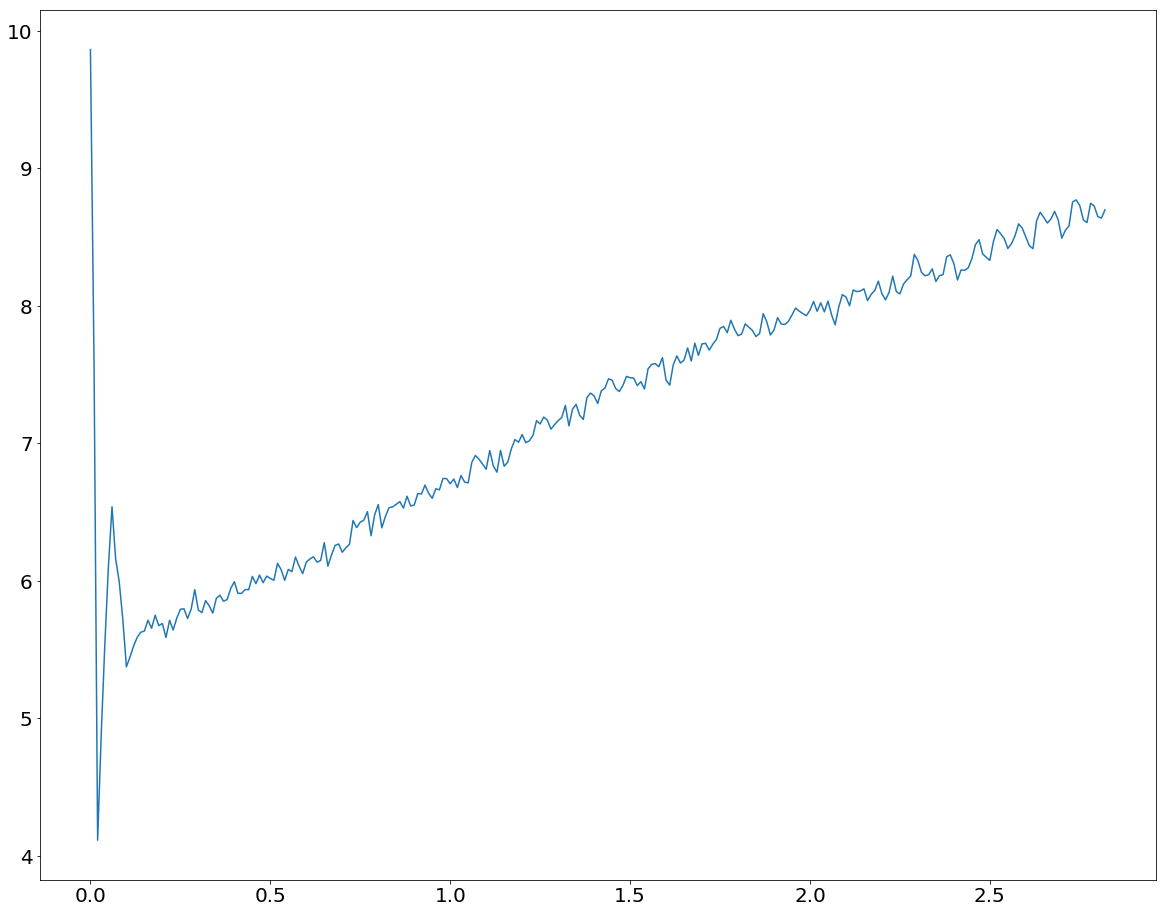

In [10]:
g30_half_mass_radius(datadir)

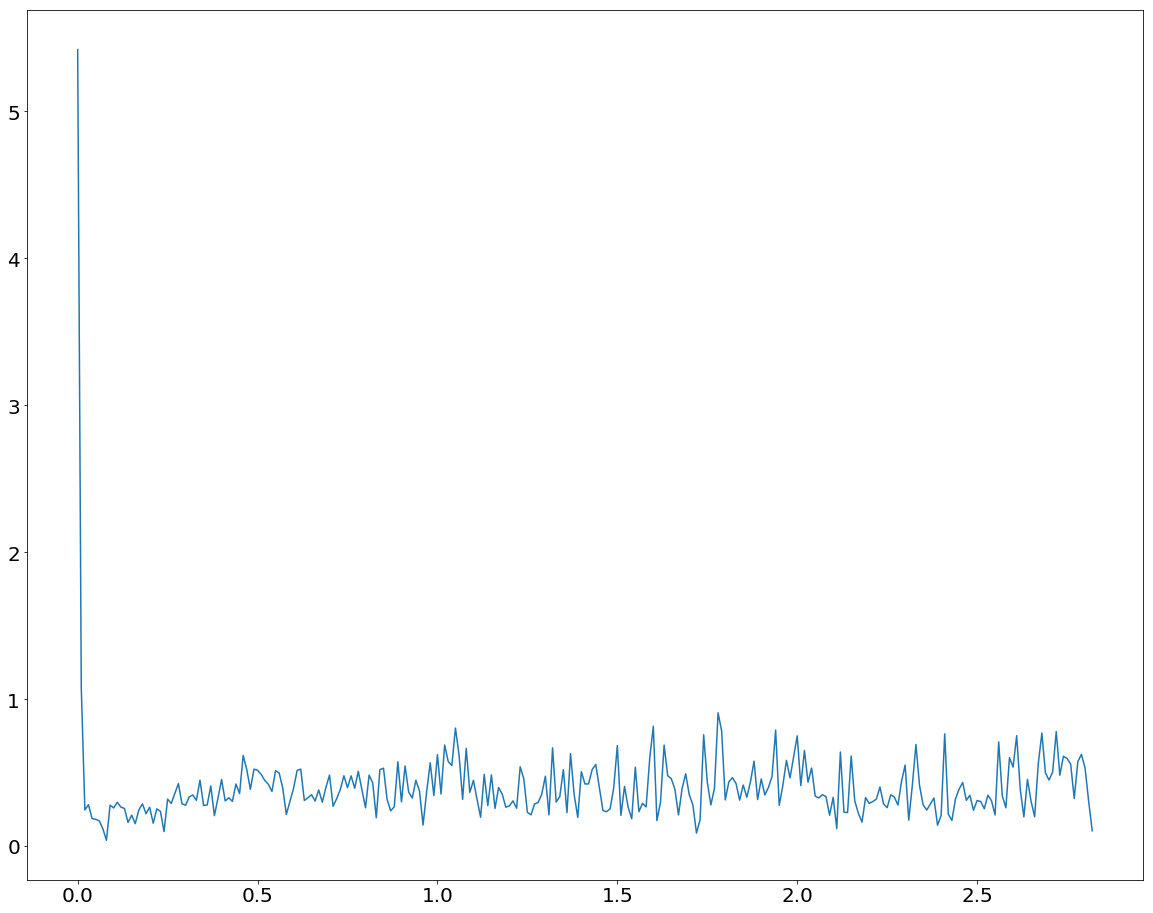

In [11]:
g30_core_radius(datadir)

In [33]:
datadir = '/home/erubin/thesis/gpfs/experiments/test64k-w3-r1-fastadj-faster2/'

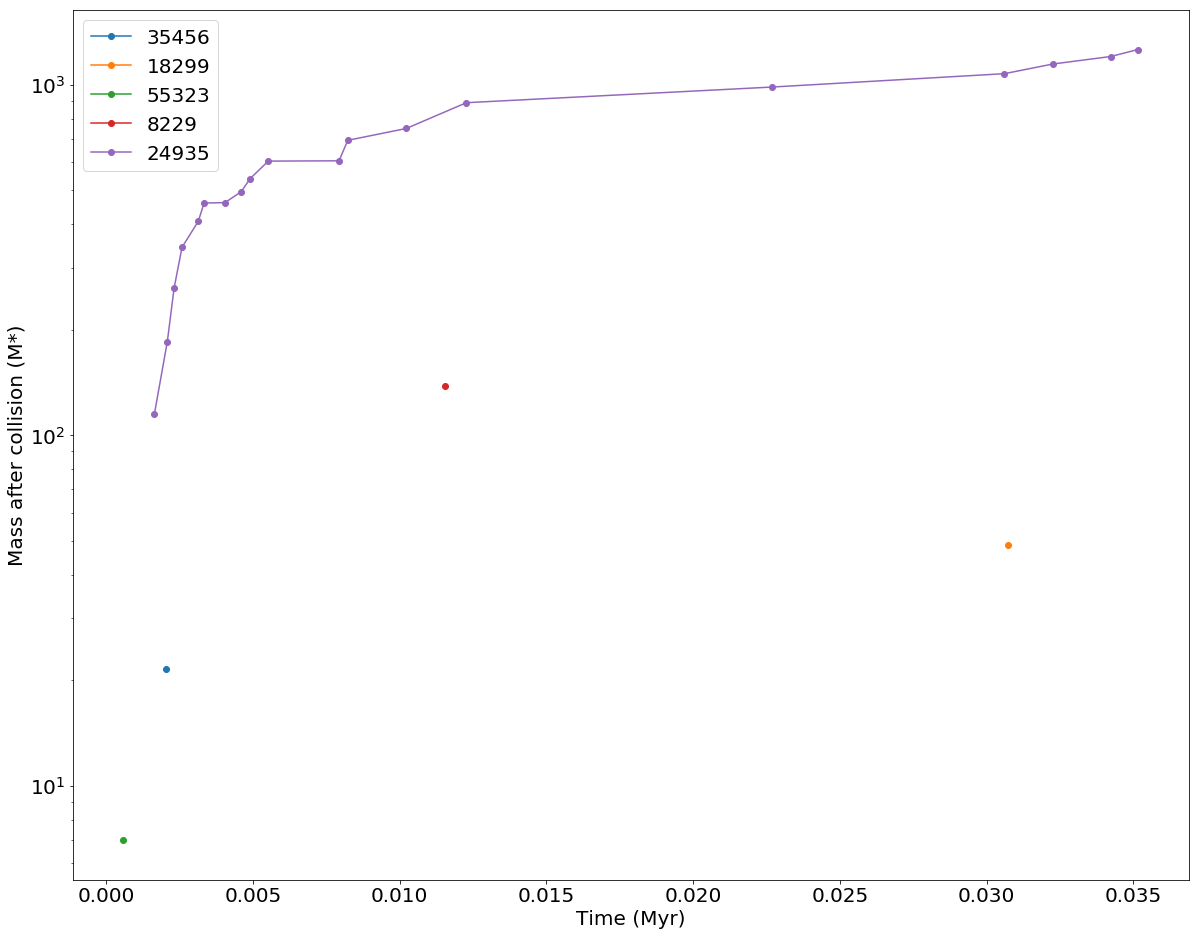

In [6]:
def collision_plot(datadir):
    to_myr = unpack.DataFile(filetools.get_conf_files(datadir)[0]).unpack().to_myr
    coll = datadir + '/coll.save'
    df = pd.read_csv(coll, sep='\s+', index_col=False, skiprows=2)
    name1 = 'NAME(I1)'
    mass='M(INEW)[M*]'
    time = 'TIME[NB]'
    labeled = collections.defaultdict(list)
    for time, name, tot in zip(df[time], df[name1], df[mass]):
        labeled[name].append(time*to_myr)
        labeled[name].append(tot)
    fig, ax = plt.subplots(1,1)
    for k, v in labeled.iteritems():
        ax.semilogy(v[0::2],v[1::2], '-o', label=k)
    ax.legend()
    ax.set_xlabel('Time (Myr)')
    ax.set_ylabel('Mass after collision (M*)')
collision_plot(datadir)

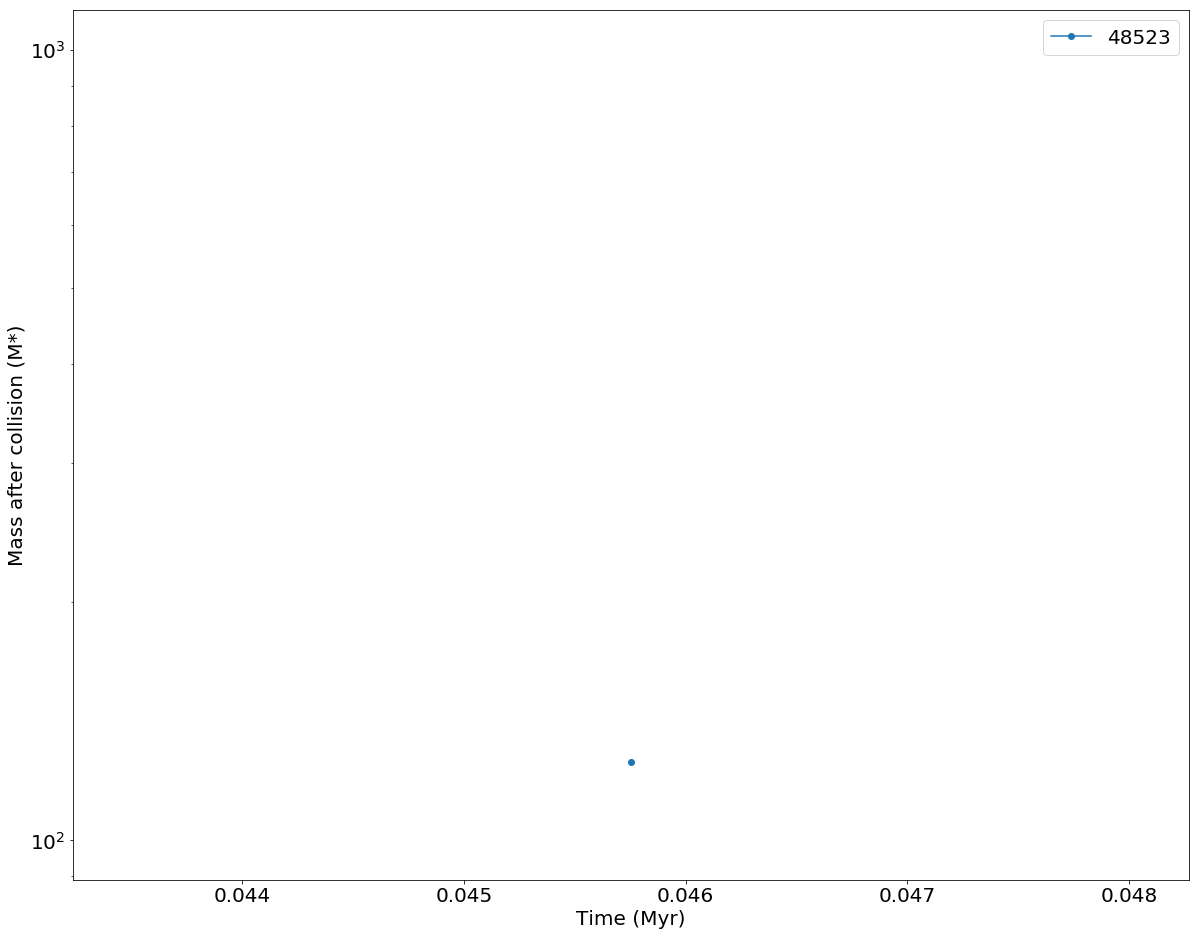

In [19]:
collision_plot('/home/erubin/thesis/gpfs/experiments/test64k-w1-m600-12-12-15:9:2//')


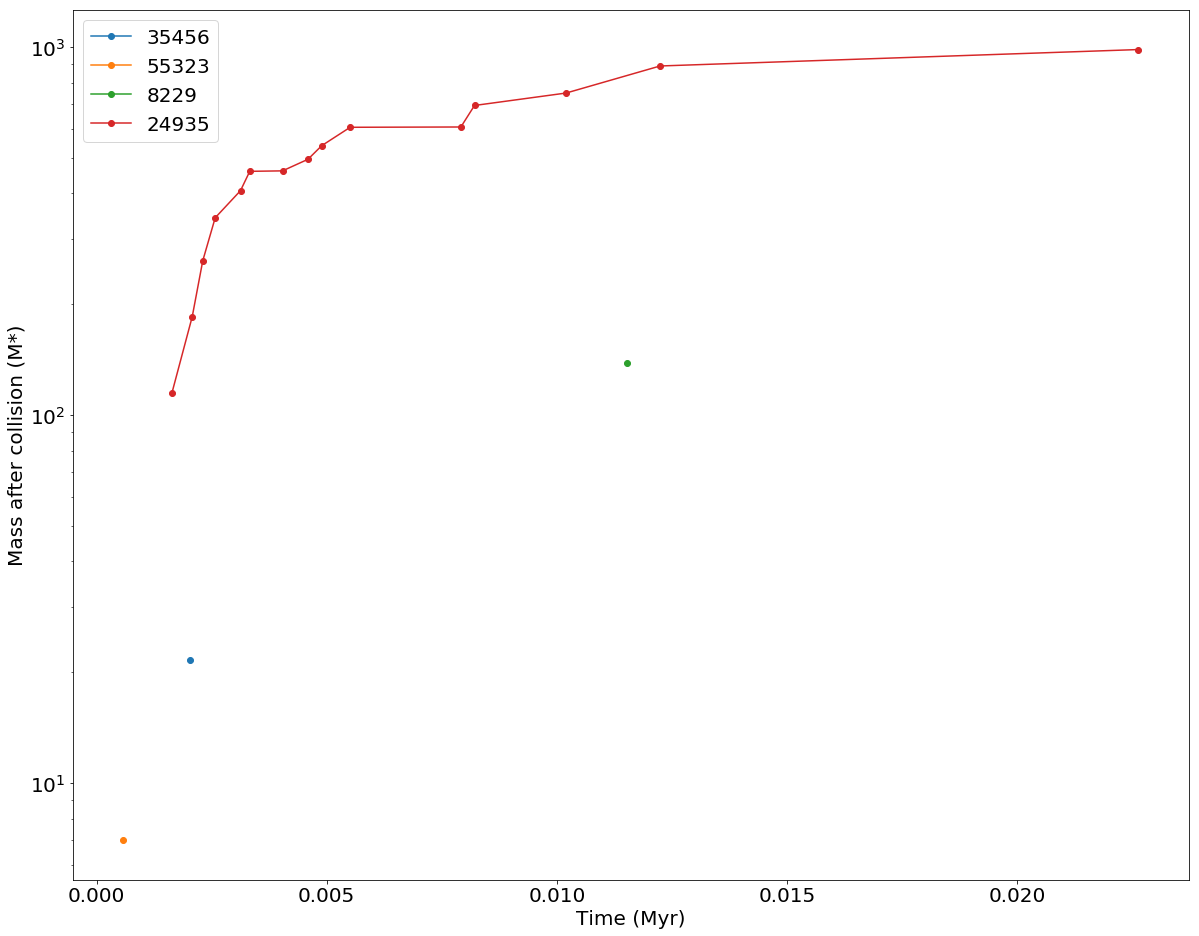

In [15]:
collision_plot('/home/erubin/thesis/gpfs/experiments/test64k-w2-m200-r1.5/out2/')